In [1]:
import cv2
from common.camera import *
from common.mocap_dataset import MocapDataset
from common.xianhui_dataset import XianhuiDataset, xianhui_data_processing
from common.skeleton import Skeleton
from common.utils import *
import glob

import plotly
import plotly.graph_objs as go
import numpy as np
import json
from common.h36m_dataset import Human36mDataset
from common.visualization import *
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

In [2]:
with open("./wild_data/2019.05.30_14.03/Plane_0.json", 'r') as f:
    data = json.loads(f.read())

In [3]:
def str2float(pts):
    return [float(pts["x"]), float(pts["y"]), float(pts["z"])]

In [4]:
pts_world = []
for i in range(6):
    for j in range(8):
        tl = data["Points"][str(i+1)][str(j+1)]["Top_Left"]
        tr = data["Points"][str(i+1)][str(j+1)]["Top_Right"]
        br = data["Points"][str(i+1)][str(j+1)]["Bottom_Right"]
        bl = data["Points"][str(i+1)][str(j+1)]["Bottom_Left"]
        pts_world.append(str2float(tl))
        pts_world.append(str2float(tr))
        pts_world.append(str2float(br))
        pts_world.append(str2float(bl))
pts_world = np.array(pts_world)

In [6]:
cam_0_data_path = "./wild_data/2019.05.30_14.03/1.json"
cam_0_img_paths = ["./wild_data/2019.05.30_14.03/BonesInfo_Camera_1/{}.png".format(str(i+1)) for i in range(49)]
cam_0_img_cal_paths = glob.glob('./wild_data/2019.05.30_14.03/Camera_0/*.png')
pts_3d, cam_0_pts_2d, cam_0_params, cam_0_imgs = xianhui_data_processing(cam_0_data_path, cam_0_img_paths, cam_0_img_cal_paths, cam_id = "cam_0", chess_board_shape = (7, 5))
# np.save("./wild_data/2019.05.30_14.03/camera_0_params.npy", cam_0_params)

calibrate camera
load 3d and 2d skeletons
estimate extrinsics


In [7]:
def world2camera(pts_3d_world_homo, rvec, tvec):
    rmat, _ = cv2.Rodrigues(rvec)
    extrinsics = np.zeros((3,4))
    extrinsics[:,:3] = rmat
    extrinsics[:,3] = tvec.reshape(-1)
    
    pts_3d_cam = np.matmul(extrinsics, pts_3d_world_homo)
    
    return pts_3d_cam

In [8]:
def camera2screen(pts_3d_cam, intrinsics):
    proj_2d = np.matmul(intrinsics, pts_3d_cam)
    proj_2d_homo = proj_2d / proj_2d[-1]
    
    return proj_2d_homo[:2].T

In [12]:
# projection from 3d to 2d
obj_pts = pts_world
proj_2d, _ = cv2.projectPoints(obj_pts, 
                               cam_0_params["rvec"], 
                               cam_0_params["tvec"], 
                               cam_0_params["intrinsics"],
                               cam_0_params["distortion"])
proj_2d = proj_2d.reshape(-1,2)

In [14]:
proj_2d.shape

(192, 2)

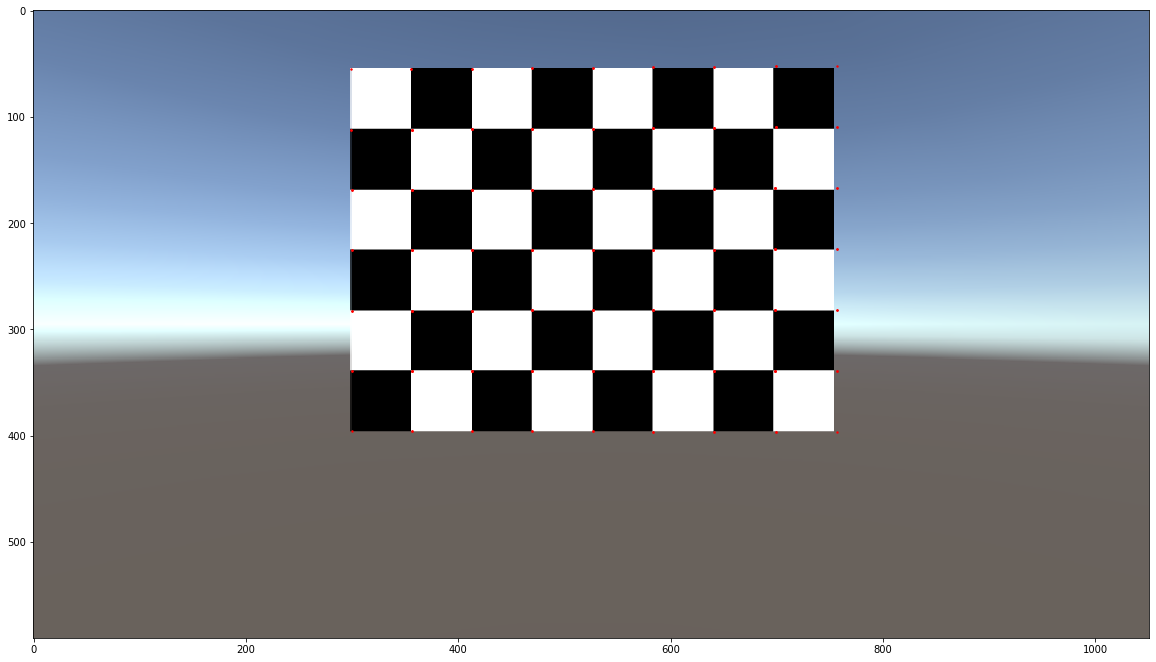

In [19]:
fig = plt.figure(figsize=(20,20))
ax_2d_gt = fig.add_subplot(1,1,1, aspect='equal')
ax_2d_gt.imshow(plt.imread("./wild_data/2019.05.30_14.03/Camera_0/1.png"))
ax_2d_gt.scatter(proj_2d[:,0], proj_2d[:,1], s = 2, color="r")